In [33]:
!pip install langchain_community langchain_core langchain_experimental typing_extensions langgraph


[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python3.11 -m pip install --upgrade pip


# Multi-Agent Supervisor Example

From https://langchain-ai.github.io/langgraph/tutorials/multi_agent/agent_supervisor/#setup

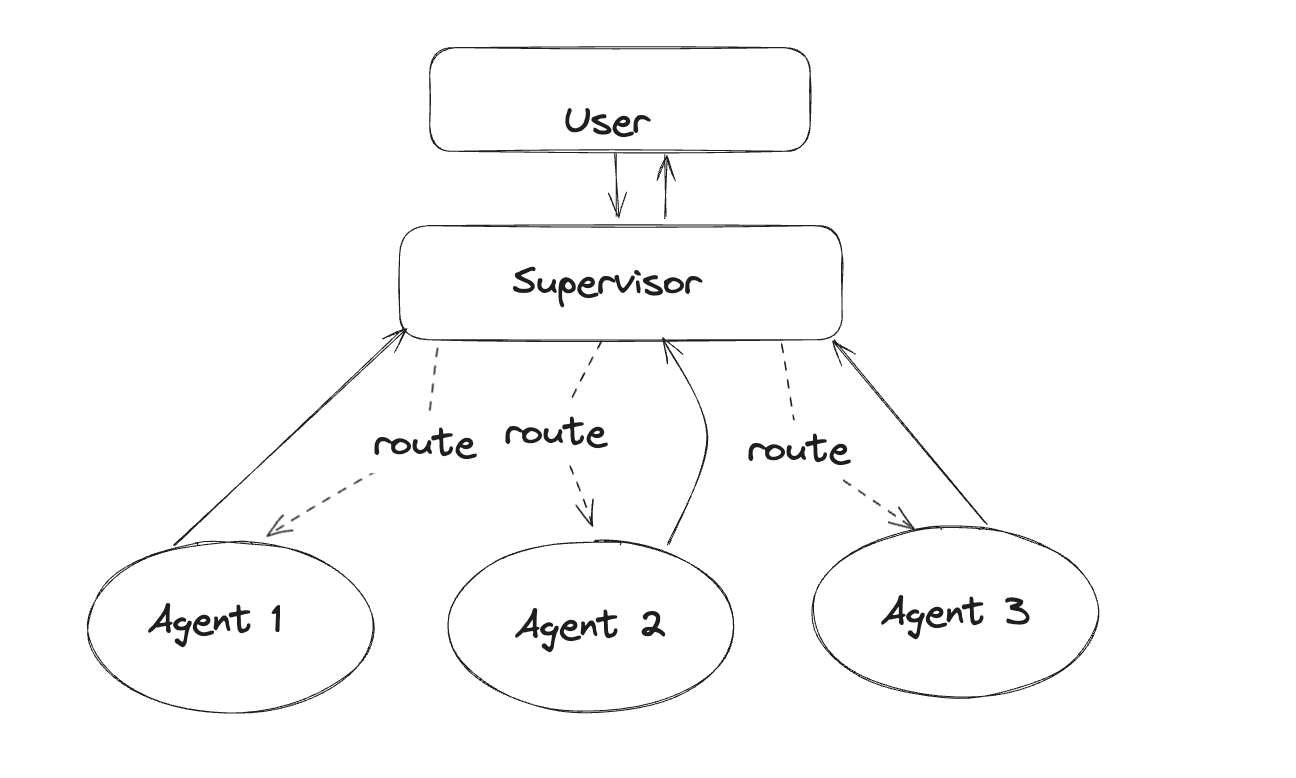

In [34]:
import os
import json
import requests
import getpass
#from langchain.llms import OpenAI ## Replacing with ChatOpenAI in this workflow because it does not work with tool bindings for LangGraph agent creation
from langchain.chat_models import ChatOpenAI
from langchain.chains import LLMChain, SequentialChain
from langchain.prompts import PromptTemplate

# Set up your API keys (ensure these are available in your environment)
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
NEWSAPI_KEY = os.getenv("NEWSAPI_KEY")
SERP_API_KEY = os.getenv("SERP_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")



# Create Tools

In [35]:
from typing import Annotated

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.tools import tool
from langchain_experimental.utilities import PythonREPL


tavily_tool = TavilySearchResults(max_results=5)

# This executes code locally, which can be unsafe
repl = PythonREPL()


@tool
def python_repl_tool(
    code: Annotated[str, "The python code to execute to generate your chart."],
):
    """Use this to execute python code and do math. If you want to see the output of a value,
    you should print it out with `print(...)`. This is visible to the user."""
    try:
        result = repl.run(code)
    except BaseException as e:
        return f"Failed to execute. Error: {repr(e)}"
    result_str = f"Successfully executed:\n\`\`\`python\n{code}\n\`\`\`\nStdout: {result}"
    return result_str

## Create agent supervisor
Users LLM with structured output to choose next worker node or stop processing

In [36]:
!pip install object

ERROR: Could not find a version that satisfies the requirement object (from versions: none)

[notice] A new release of pip is available: 24.2 -> 25.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
ERROR: No matching distribution found for object


In [46]:
from typing import Literal
from typing_extensions import TypedDict
import json
import re

from langgraph.graph import MessagesState, END
from langgraph.types import Command


members = ["researcher", "coder"]
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = members + ["FINISH"]

system_prompt = (
    "You are a supervisor managing a conversation between the following workers: "
    f"{members}. Given the user request and worker responses, "
    "determine which worker should act next. When no workers are needed, respond with 'FINISH'.\n\n"
    "Always respond in the following JSON format:\n"
    '{ "next": "<worker_name>" }\n'
    "where <worker_name> is one of the following: " + ", ".join(options)
)



class Router(TypedDict):
    """Worker to route to next. If no workers needed, route to FINISH."""

    next: Literal[*options]


from langchain.chat_models import ChatOpenAI

def dummy_bind_tools(self, tools, **kwargs):
    # Option 1: Simply attach the tools via object.__setattr__ to bypass Pydantic checks.
    object.__setattr__(self, "tools", tools)
    return self

ChatOpenAI.bind_tools = dummy_bind_tools

llm = ChatOpenAI(temperature=0, openai_api_key=OPENAI_API_KEY)


class State(MessagesState):
    next: str

def extract_json(text: str):
    """
    Extracts the first valid JSON object or array from a string.

    Args:
        text (str): The input string containing JSON.

    Returns:
        dict or list: The extracted JSON object or list if successful, else None.
    """
    # Remove code block markers if present
    text = text.strip().replace("```json", "").replace("```", "").strip()

    # Look for the first '{' and last '}' (for dictionaries)
    match = re.search(r"\{.*\}", text, re.DOTALL)
    if not match:
        # If no dict, look for first '[' and last ']' (for lists)
        match = re.search(r"\[.*\]", text, re.DOTALL)

    if match:
        json_str = match.group(0)
        try:
            return json.loads(json_str)
        except json.JSONDecodeError:
            print("Error: Extracted JSON is invalid.")
            return None
    else:
        print("Error: No JSON found in text.")
        return None

def supervisor_node(state: State) -> Command[Literal[*members, "__end__"]]:
    messages = [
        {"role": "system", "content": system_prompt},
    ] + state["messages"]
    # Attempt to parse response as JSON
    raw_response = llm.invoke(messages).content.strip()  # Get raw text output
    
    try:
        response = extract_json(raw_response)
        goto = response.get("next", "FINISH")  # Default to FINISH if missing
    except json.JSONDecodeError:
        print("Error: Supervisor response not in JSON format:", raw_response)
        goto = "FINISH"
    if goto == "FINISH":
        goto = END

    return Command(goto=goto, update={"next": goto})

In [47]:
# Construct Graph

from langchain_core.messages import HumanMessage
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import create_react_agent





research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt="You are a researcher. DO NOT do any mathematics."
)

# use state modifier instead?

def research_node(state: State) -> Command[Literal["supervisor"]]:
    result = research_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="researcher")
            ]
        },
        goto="supervisor",
    )


# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
code_agent = create_react_agent(llm, tools=[python_repl_tool])


def code_node(state: State) -> Command[Literal["supervisor"]]:
    result = code_agent.invoke(state)
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content, name="coder")
            ]
        },
        goto="supervisor",
    )


builder = StateGraph(State)
builder.add_edge(START, "supervisor")
builder.add_node("supervisor", supervisor_node)
builder.add_node("researcher", research_node)
builder.add_node("coder", code_node)
graph = builder.compile()

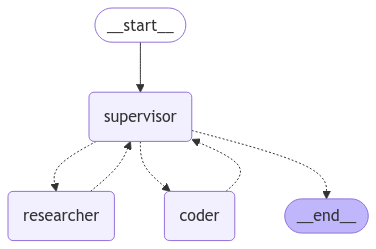

In [43]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

# Invoke the team

In [49]:
for s in graph.stream(
    {"messages": [("user", "What's the square root of 42?")]}, subgraphs=True
):
    print(s)
    print("----")

((), {'supervisor': {'next': 'researcher'}})
----
(('researcher:b7ae586e-96dc-b2db-d249-9e85969ceeb3',), {'agent': {'messages': [AIMessage(content='The square root of 42 is an irrational number, approximately equal to 6.48.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 20, 'prompt_tokens': 31, 'total_tokens': 51, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-a131d07a-104e-4c80-a014-b41c41afa59b-0')]}})
----
((), {'researcher': {'messages': [HumanMessage(content='The square root of 42 is an irrational number, approximately equal to 6.48.', additional_kwargs={}, response_metadata={}, name='researcher')]}})
----
((), {'supervisor': {'next': '__end__'}})
----
